In [1]:
import pandas as pd
import anndata
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt
from os.path import join
import os
import numpy as np

# Curate expression data

In [2]:
CORTEX_URL = "https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt"

In [3]:
# meta information
df_meta = pd.read_csv(CORTEX_URL, nrows=10, sep="\t", header=None)
df_meta = df_meta.iloc[:, 1:].T
columns = df_meta.iloc[0, :]
df_meta = df_meta.iloc[1:, :]
df_meta.columns = columns
df_meta = df_meta.set_index("cell_id")
df_meta.columns.name = None
df_meta["total mRNA mol"] = df_meta["total mRNA mol"].astype(float)

# expression information
df_expr = pd.read_csv(CORTEX_URL, skiprows=11, sep="\t", header=None).set_index(0)
df_expr.index.name = "gene"
df_gene_backspin = df_expr.iloc[:, [0]]
df_gene_backspin.columns = ["BackSPIN"]
df_expr = df_expr.iloc[:, 1:]
df_expr.columns = df_meta.index
df_expr = df_expr.T
adata = AnnData(df_expr, obs=df_meta, var=df_gene_backspin)

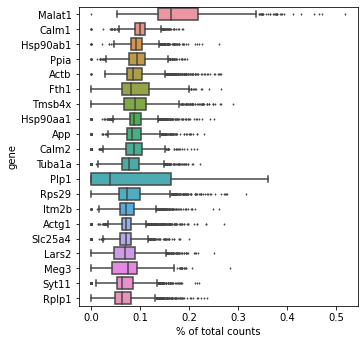

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=30)

adata.raw = adata

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highest_expr_genes(
    adata,
    n_top=20,
)

adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.set_figure_params(dpi=150)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

raw_adata = adata.raw.to_adata()
raw_adata.obsp = adata.obsp

In [5]:
df_cov = pd.DataFrame(index=adata.obs.index)
df_cov["const"] = 1
df_cov["n_genes"] = adata.obs["n_genes"]

... storing 'tissue' as categorical
... storing 'group #' as categorical
... storing 'well' as categorical
... storing 'sex' as categorical
... storing 'age' as categorical
... storing 'diameter' as categorical
... storing 'level1class' as categorical
... storing 'level2class' as categorical


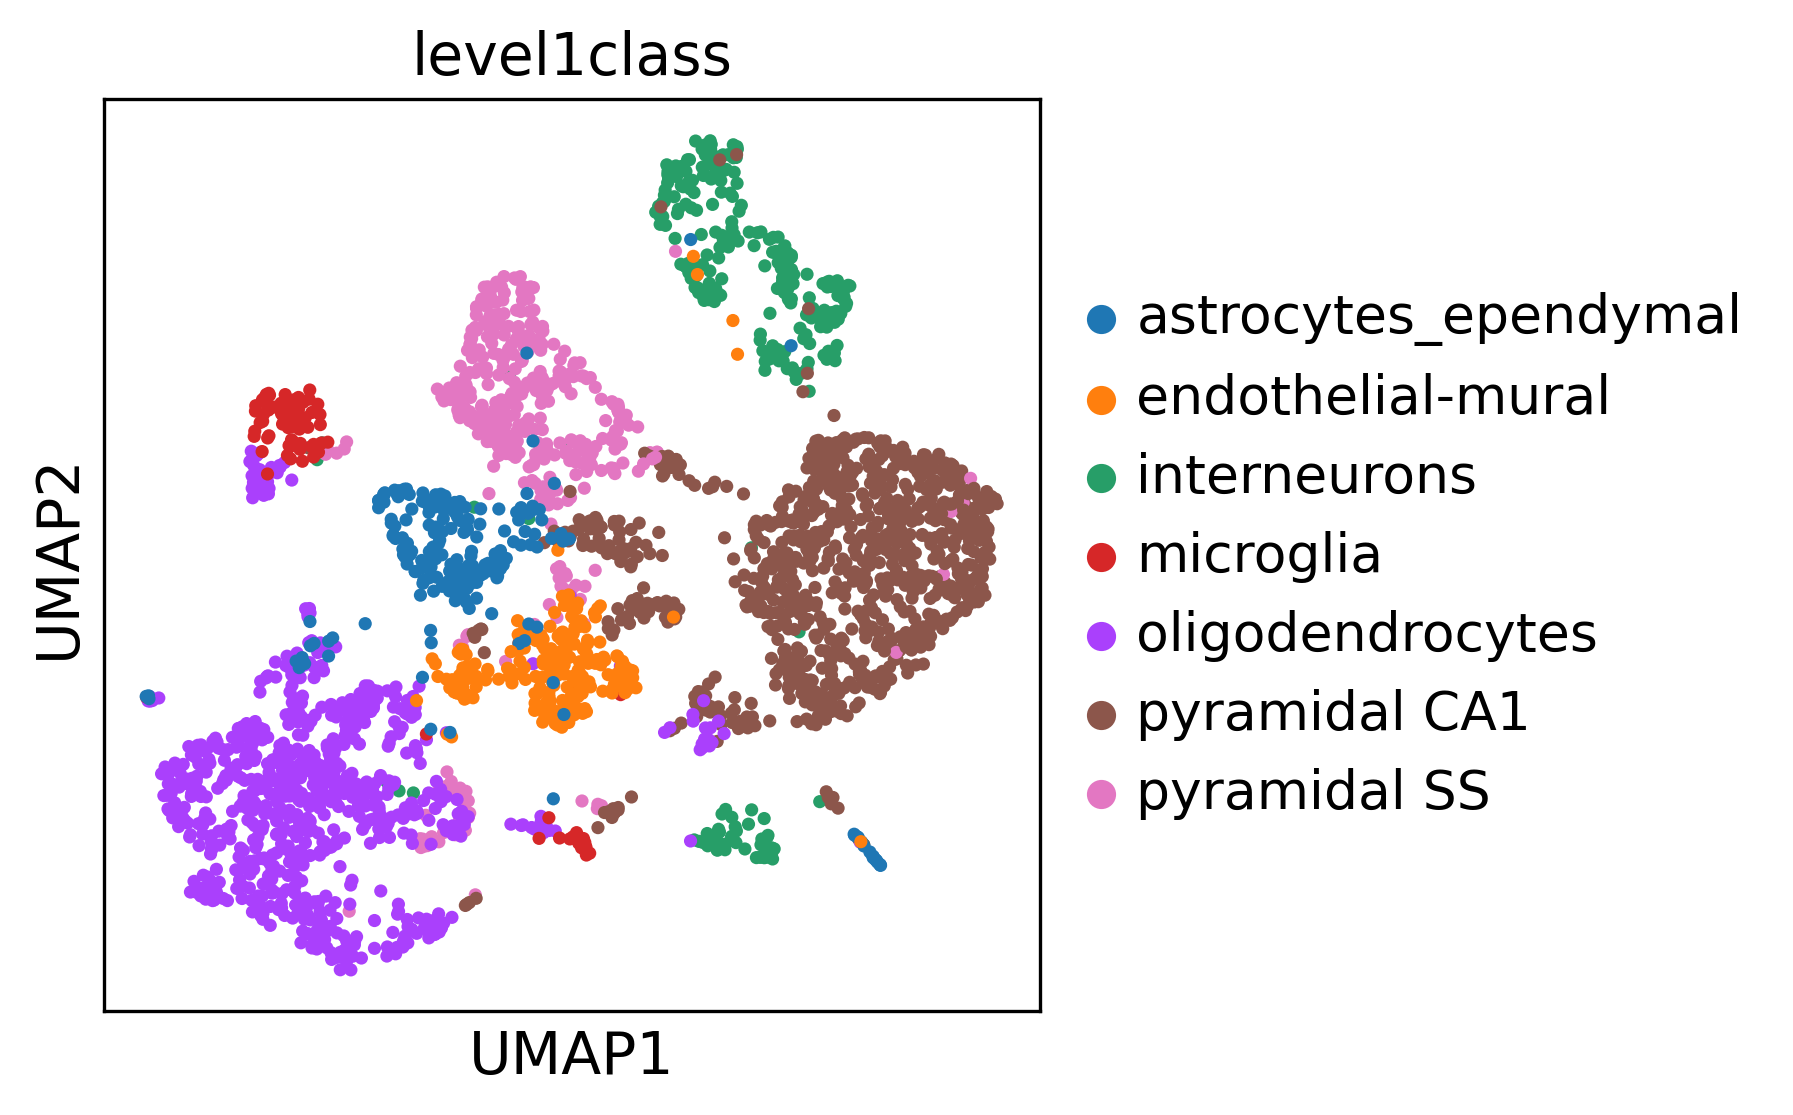

In [6]:
sc.pl.umap(adata, color=["level1class"], ncols=1, size=40)

In [7]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121"

In [14]:
out_dir = join(DATA_PATH, "single_cell_data/zeisel_2015")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

raw_adata.write_h5ad(join(out_dir, "expr.h5ad"))
df_cov.to_csv(join(out_dir, "cov.tsv"), sep="\t")

... storing 'tissue' as categorical
... storing 'group #' as categorical
... storing 'well' as categorical
... storing 'sex' as categorical
... storing 'age' as categorical
... storing 'diameter' as categorical
... storing 'level1class' as categorical
... storing 'level2class' as categorical


# Curate geneset

In [9]:
df_hom = pd.read_csv(
    join(DATA_PATH, "gene_annotation/", "mouse_human_homologs.txt"),
    sep="\t",
)
dict_hom = {row[1]: row[0] for _, row in df_hom.iterrows()}

In [10]:
TRAIT_LIST = [
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Pardinas2018",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_COLLEGE",
    "UKB_460K.body_BMIz",
    "UKB_460K.body_HEIGHTz",
]

In [11]:
gs_path = join(DATA_PATH, "gs_file/magma_10kb_1000.74_traits.gs")
df_magma_gs = pd.read_csv(gs_path, sep="\t")
df_magma_gs = df_magma_gs[df_magma_gs.TRAIT.isin(TRAIT_LIST)].reset_index(drop=True)

df_magma_gs["GENESET"] = df_magma_gs["GENESET"].apply(
    lambda r: ",".join([dict_hom[g] for g in r.split(",") if g in dict_hom])
)

In [12]:
# download GSE67403_gene_exp.diff.gz from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE67403
diff_expr = pd.read_csv("GSE67403_gene_exp.diff.gz", sep="\t")
regions = [
    "dorsal",
    "intermediate",
    "ventral",
    "proximal",
    "distal",
    "superficial",
    "deep",
]

dict_diff_genes = dict()
FOLD_CHANGE_THRES = 2

diff_expr = diff_expr[
    diff_expr.sample_1.isin(regions) & diff_expr.sample_2.isin(regions)
]
diff_expr = diff_expr[
    ((diff_expr.value_1 > 10) | (diff_expr.value_2 > 10)) & (diff_expr.q_value < 0.05)
]

diff_long = diff_expr[
    (diff_expr.sample_1 == "dorsal") & (diff_expr.sample_2 == "ventral")
]
diff_long = diff_long[
    (np.abs(diff_long["log2(fold_change)"]) > np.log2(FOLD_CHANGE_THRES))
]
diff_transverse = diff_expr[
    (diff_expr.sample_1 == "proximal") & (diff_expr.sample_2 == "distal")
]
diff_transverse = diff_transverse[
    (np.abs(diff_transverse["log2(fold_change)"]) > np.log2(FOLD_CHANGE_THRES))
]
diff_radial = diff_expr[
    (diff_expr.sample_1 == "superficial") & (diff_expr.sample_2 == "deep")
]
diff_radial = diff_radial[
    (np.abs(diff_radial["log2(fold_change)"]) > np.log2(FOLD_CHANGE_THRES))
]

dict_diff_genes[f"ventral"] = diff_long[diff_long.test_stat > 0].gene.values
dict_diff_genes[f"dorsal"] = diff_long[diff_long.test_stat < 0].gene.values

dict_diff_genes[f"distal"] = diff_transverse[diff_transverse.test_stat > 0].gene.values
dict_diff_genes[f"proximal"] = diff_transverse[
    diff_transverse.test_stat < 0
].gene.values

dict_diff_genes[f"deep"] = diff_radial[diff_radial.test_stat > 0].gene.values
dict_diff_genes[f"superficial"] = diff_radial[diff_radial.test_stat < 0].gene.values

from os.path import join

df_spatial_gs = {"TRAIT": [], "GENESET": []}
for trait in dict_diff_genes:
    df_spatial_gs["TRAIT"].append("spatial_" + trait)
    df_spatial_gs["GENESET"].append(
        ",".join([g for g in dict_diff_genes[trait] if g in dict_hom.values()])
    )
df_spatial_gs = pd.DataFrame(df_spatial_gs)

In [13]:
df_gs = pd.concat([df_magma_gs, df_spatial_gs])
df_gs.to_csv(
    join(DATA_PATH, "single_cell_data/zeisel_2015/geneset.gs"), sep="\t", index=False
)